In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/data/train_sample/'

In [ ]:
#Uncomment only when installing Keras OCR (Need to do it only once)
!pip install keras_ocr

     |████████████████████████████████| 41 kB 330 kB/s 
     |████████████████████████████████| 895 kB 10.6 MB/s 
     |████████████████████████████████| 603 kB 41.1 MB/s 
     |████████████████████████████████| 9.5 MB 34.5 MB/s 
     |████████████████████████████████| 50 kB 6.5 MB/s 


In [ ]:
import cv2 as cv
from google.colab.patches import cv2_imshow
import os
import numpy as np
import skimage
from skimage import data
from skimage.measure import shannon_entropy
from skimage.feature import greycomatrix, greycoprops
from skimage import measure
import matplotlib.pyplot as plt
import math
import scipy
import pandas as pd
from PIL import Image, ImageStat,ImageOps
import keras_ocr
from skimage.filters import threshold_yen, threshold_li
import skimage.io
from numpy import asarray
#import Image_preprocessing as process

pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [ ]:
imgList = [cv.imread(path + file) for file in os.listdir(path)]#path = '/content/drive/My Drive/data/train_sample/'

Functions to extract Feature values

In [ ]:
## Function to return Shannon Entropy value of image
def getEntropy(image):
  if(len(image.shape)==3):
    img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  elif(len(image.shape)<3):
    img = image
  entropy = shannon_entropy(img)
  #print(entropy)
  return entropy


In [ ]:
def getHuMoments(image):
  if(len(image.shape)==3):
    img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  elif(len(image.shape)<3):
    img = image
  humoments = []
  mu = measure.moments_central(img)
  nu = measure.moments_normalized(mu)
  hu_moments = measure.moments_hu(nu)

  #Log Transform to bring Hu Moments in a comparable range
  for i in range(0,len(hu_moments)):
    hu_moments[i] = -1* (math.copysign(1.0, hu_moments[i]) * math.log10(abs(hu_moments[i])))
    humoments.append(hu_moments[i])
  
  #print(hu_moments)
  return humoments

In [ ]:
def getCentroid(image):
    if(len(image.shape)==3):
      img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    elif(len(image.shape)<3):
      img = image

    h,w = np.shape(img)
    x = range(w)
    y = range(h)
    X,Y = np.meshgrid(x,y)

    #Centroid (mean)
    cx = np.sum(img*X)/np.sum(img)
    cy = np.sum(img*Y)/np.sum(img)

    return cx,cy

In [ ]:
def getVariance(image):
    if(len(image.shape)==3):
      img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    elif(len(image.shape)<3):
      img = image

    h,w = np.shape(img)
    cx, cy = getCentroid(img)
    ###Standard deviation
    x2 = (range(w) - cx)**2
    y2 = (range(h) - cy)**2

    X2,Y2 = np.meshgrid(x2,y2)

    #Find the variance
    varianceX = np.sum(img*X2)/np.sum(img)
    varianceY = np.sum(img*Y2)/np.sum(img)
    
    return varianceX, varianceY

In [ ]:
def getStandardDeviation(image):
    if(len(image.shape)==3):
      img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    elif(len(image.shape)<3):
      img = image

    vx, vy = getVariance(img)
    sdX = np.sqrt(vx)
    sdY = np.sqrt(vy)
    
    return sdX,sdY

In [ ]:
def getSkew(image):
    if(len(image.shape)==3):
      img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    elif(len(image.shape)<3):
      img = image

    h,w = np.shape(img)
    cx,cy = getCentroid(img)
    sx,sy = getStandardDeviation(img)

    ###Skewness
    x3 = (range(w) - cx)**3
    y3 = (range(h) - cy)**3

    X3,Y3 = np.meshgrid(x3,y3)

    #Find the third central moment
    m3x = np.sum(img*X3)/np.sum(img)
    m3y = np.sum(img*Y3)/np.sum(img)

    #Skewness is the third central moment divided by SD cubed
    skx = m3x/sx**3
    sky = m3y/sy**3
    
    return skx, sky


In [ ]:
def getKurtosis(image):
    if(len(image.shape)==3):
      img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    elif(len(image.shape)<3):
      img = image
  
    h,w = np.shape(img)
    cx,cy = getCentroid(img)
    sx,sy = getStandardDeviation(img)

     ###Kurtosis
    x4 = (range(w) - cx)**4
    y4 = (range(h) - cy)**4

    X4,Y4 = np.meshgrid(x4,y4)

    #Find the fourth central moment
    m4x = np.sum(img*X4)/np.sum(img)
    m4y = np.sum(img*Y4)/np.sum(img)

    #Kurtosis is the fourth central moment divided by SD to the fourth power
    kx = m4x/sx**4
    ky = m4y/sy**4
    
    return kx, ky

In [ ]:
def getGlCM_Matrix(image):
  if(len(image.shape)==3):
      img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  elif(len(image.shape)<3):
      img = image
  GLCM_List = []
  comatrix = greycomatrix(np.array(img), [1,2,4,8], [0, np.pi/4, np.pi/2, 3*np.pi/4],levels=256)

  contrast = greycoprops(comatrix,'contrast').flatten()
  for contr in contrast:
    GLCM_List.append(round(contr,5))

  energy = greycoprops(comatrix, 'energy').flatten()
  for enrgy in energy:
    GLCM_List.append(round(enrgy,5))

  dissimilarity = greycoprops(comatrix, 'dissimilarity').flatten()
  for diss in dissimilarity:
    GLCM_List.append(round(diss,5))

  homogeneity = greycoprops(comatrix, 'homogeneity').flatten()
  for hom in homogeneity:
    GLCM_List.append(round(hom,5))
  
  correlation = greycoprops(comatrix, 'correlation').flatten()
  for corr in correlation:
    GLCM_List.append(round(corr,5))

  ASM = greycoprops(comatrix, 'ASM').flatten()
  for asm in ASM:
    GLCM_List.append(round(asm,5))
  
  ##print(len(GLCM_List))
  return GLCM_List

In [ ]:
def getRMS(imagePath):
  img = Image.open(imagePath)
  grImg = ImageOps.grayscale(img)
  stat = ImageStat.Stat(grImg)
  #print(stat.rms)
  return stat.rms[0]

Preprocessing Functions

In [ ]:
def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2)/2)
    y_mid = int((y1 + y2)/2)
    return (x_mid, y_mid)


# def remove_text(img_path):
def remove_text(img):    #pipeline = keras_ocr.pipeline.Pipeline()

    # read image
    # img = keras_ocr.tools.read(img_path)

    # generate (word, box) tuples 
    prediction_groups = pipeline.recognize([img])
    mask = np.zeros(img.shape[:2], dtype="uint8")

    for box in prediction_groups[0]:
        x0, y0 = box[1][0]
        x1, y1 = box[1][1] 
        x2, y2 = box[1][2]
        x3, y3 = box[1][3] 
        
        x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
        x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)
        
        thickness = int(math.sqrt( (x2 - x1)**2 + (y2 - y1)**2 ))
        
        cv.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), 255, thickness)
    
    removed_text_img = cv.inpaint(img, mask, 100, cv.INPAINT_NS)
      
    return removed_text_img

In [ ]:
def change_contrast(image):
    if(len(image.shape)==3):
        bwImage = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    elif(len(image.shape)<3):
        bwImage = image
    clahe = cv.createCLAHE(clipLimit = 3, tileGridSize = (10, 10))
    contrast_image = clahe.apply(bwImage)
    return contrast_image

In [ ]:
def gammaCorrection(image, gamma = 2):
    if(len(image.shape)==3):
        img = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    elif(len(image.shape)<3):
        img = image
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)
    gammaImg = cv.LUT(img, table)
    return gammaImg

In [ ]:
def threshhold(image):
  #threshVal = threshold_li(image)
  threshVal, threshImg  = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
  #ret,threshImg = cv.threshold(image,threshVal,255,cv.THRESH_BINARY_INV)
  return threshImg

In [ ]:
def center_crop(img):
    dim = (240, 230)
    width, height = img.shape[1], img.shape[0]
    # process crop width and height for max available dimension
    crop_width = dim[0] if dim[0]<img.shape[1] else img.shape[1]
    crop_height = dim[1] if dim[1]<img.shape[0] else img.shape[0] 
    mid_x, mid_y = int(width/2), int(height/2)
    cw2, ch2 = int(crop_width/2), int(crop_height/2) 
    crop_img = img[mid_y-ch2:mid_y+ch2, mid_x-cw2:mid_x+cw2]
    return crop_img

In [ ]:
def morphOps(image):
  kerneld = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
  dilatedImg = cv.dilate(image,kerneld,iterations = 2)
  #cv2_imshow(dilatedImg)
  kernelcl = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
  closedImg = cv.morphologyEx(dilatedImg, cv.MORPH_CLOSE, kernelcl)
  #cv2_imshow(closedImg)
  kernelo = cv.getStructuringElement(cv.MORPH_ELLIPSE,(3,3))
  openedImg = cv.morphologyEx(closedImg, cv.MORPH_OPEN, kernelo)
  #cv2_imshow(openedImg)
  kernelcl2 = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
  secondclosedImg = cv.morphologyEx(openedImg, cv.MORPH_CLOSE, kernelcl2)
  #cv2_imshow(secondclosedImg)
  return secondclosedImg


In [ ]:
def getSegmented(originalImg, thresholdedImg):
  if(len(originalImg.shape)==3):
        origImg = cv.cvtColor(originalImg, cv.COLOR_RGB2GRAY)
  elif(len(originalImg.shape)<3):
        origImg = originalImg

  originalImgarray = asarray(origImg)
  threshImgarray = asarray(thresholdedImg)
  segmentedImg = np.zeros(originalImgarray.shape, np.uint8)
  
  for i in range(0, originalImgarray.shape[0]):
    for j in range(0, originalImgarray.shape[1]):
      if ((threshImgarray)[i, j] == 255):
        segmentedImg[i,j] = (originalImgarray)[i, j]

  return segmentedImg

In [ ]:
def equalizeHistImg(image):
  bwImage = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  eqImage = cv.equalizeHist(bwImage)
  return eqImage

In [ ]:
def preProcess(imagePath):
  textRemovedImg = remove_text(imagePath)   # Remove Text
  # print('text')
  # cv2_imshow(textRemovedImg)

  croppedImg = center_crop(textRemovedImg)  # Crop Image
  # print('crop')
  # cv2_imshow(croppedImg)

  contrastImg = change_contrast(croppedImg) # Adjust Constrast of Image
  # print('contrasr')
  # cv2_imshow(contrastImg)

  gammaImg = gammaCorrection(contrastImg)   # Gamma Correction
  # print('gamma')
  # cv2_imshow(gammaImg)

  threshImg = threshhold(gammaImg)                 # Threshold Image 
  # print('thresh')
  # cv2_imshow(threshImg)

  morphImg = morphOps(threshImg)            # Morphological Operations
  # print('morp')
  # cv2_imshow(morphImg)

  processedImg = getSegmented(contrastImg,morphImg)
  # print('segment')
  # cv2_imshow(processedImg)
  return processedImg#textRemovedImg,croppedImg,contrastImg,gammaImg,threshImg,morphImg,

In [ ]:
Hori1.shape

(230, 6740, 3)

6
eins 6


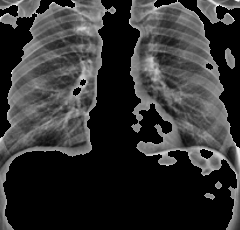

29
zwo 29


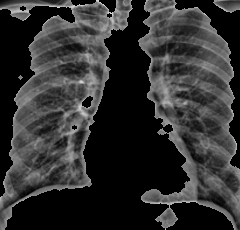

44
zwo 44


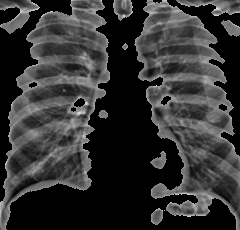

60
True else 60


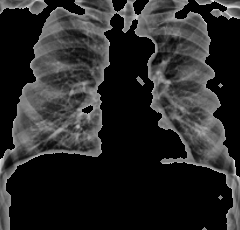

78


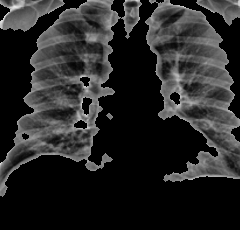

94
0 if 94


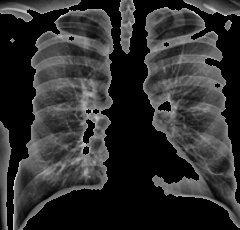

99
1 else 99


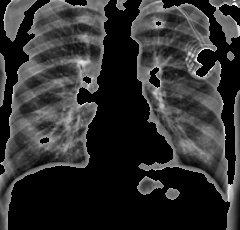

100


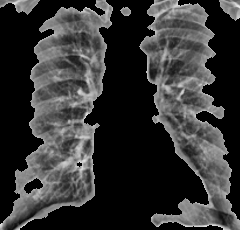

102
0 if 102


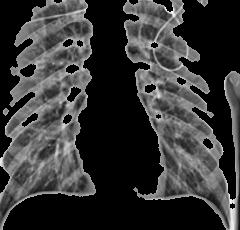

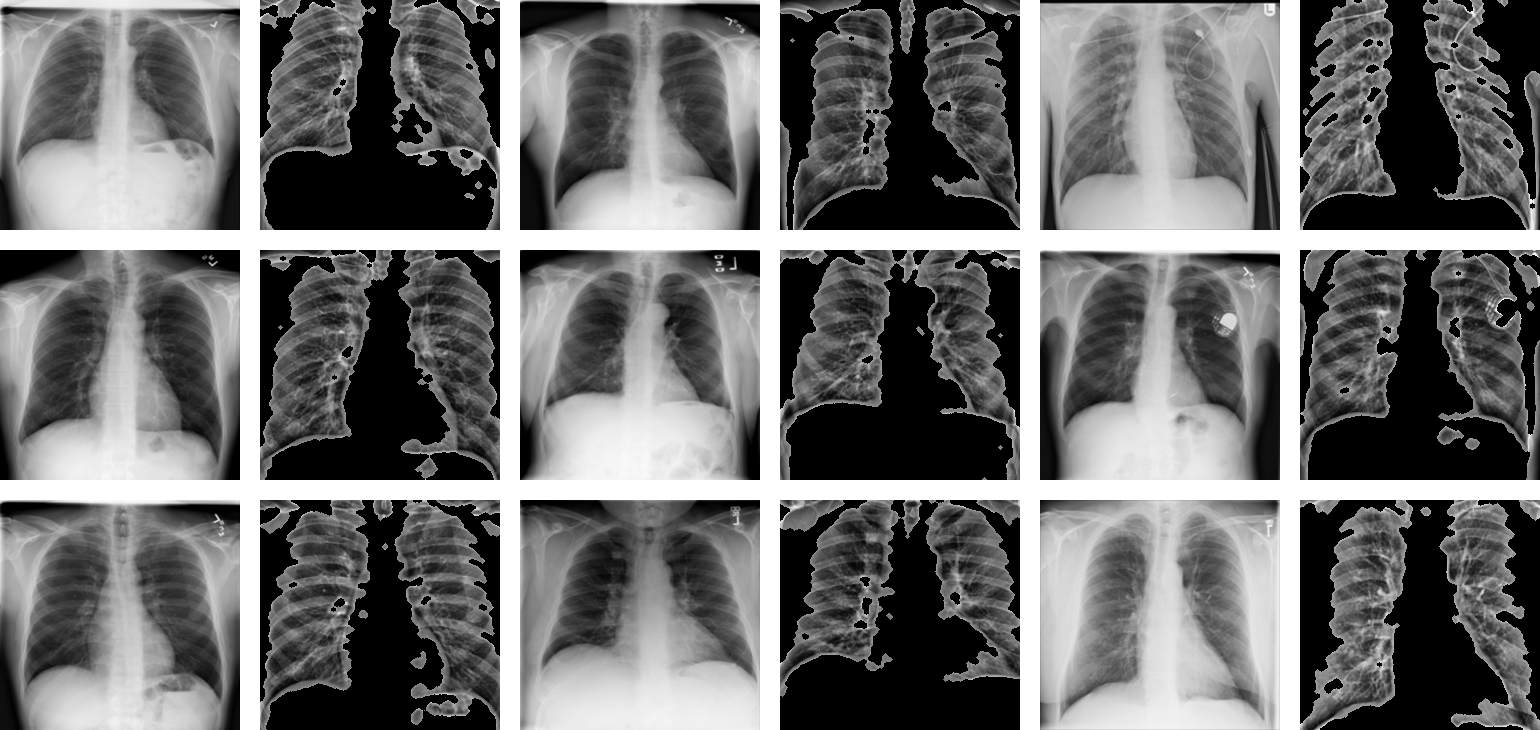

In [ ]:
path = '/content/drive/My Drive/data/train/'
# [cv.imread(path + file) for file in os.listdir(path)]
#[6
ind_list = [6,14,29,43,44,50,57,60,71,78,86,94,99,100,101,102,106,110]
# ind_list = [5,82]
ind_list = [6,29,44,60,78,94,99,100,102]
break_point = 1000
img_h = np.ones([230,20,3],dtype=np.uint8) *256
img_v = np.ones([20,1020 ,3],dtype=np.uint8) *256
temp = True
for ind,file in enumerate(os.listdir(path)):
  if ind <= break_point:
    if ind not in ind_list:
      continue
  im = cv.imread(path + file)
  print(ind)
  dim = (240,230)


  # cv2_imshow(im)
  im_p = preProcess(im)
  im_p = np.stack((im_p,)*3, axis=-1)

  im = cv.resize(im, dim,interpolation = cv.INTER_AREA)
  if ind == ind_list[0]:
    print('eins',ind)

    Hori1 = im.copy()
    Hori1 = np.concatenate((Hori1,img_h, im_p), axis=1)
  elif ind == ind_list[1]:
    print('zwo',ind)

    Hori2 = im.copy()
    Hori2 = np.concatenate((Hori2,img_h,im_p), axis=1)
  elif ind == ind_list[2]:
    print('zwo',ind)

    Hori3 = im.copy()
    Hori3 = np.concatenate((Hori3,img_h,im_p), axis=1)
  else:
    if temp == 0:
      print(temp,'if',ind)
      temp = 1
      Hori1 = np.concatenate((Hori1,img_h, im,img_h, im_p), axis=1)
    elif temp == 1:

      print(temp,'else',ind)
      temp = 2
      Hori2 = np.concatenate((Hori2,img_h, im,img_h, im_p), axis=1)   
    else:
      temp = 0
      Hori3 = np.concatenate((Hori3,img_h, im,img_h, im_p), axis=1)   
  cv2_imshow(im_p)
  # if ind > break_point +100:
  if ind == ind_list[-1]:
    break


img_v = np.ones([20,Hori2.shape[1] ,3],dtype=np.uint8) *256
    
img_f = np.concatenate((Hori1,img_v, Hori2,img_v, Hori3), axis=0)

cv2_imshow(img_f) 


AttributeError: ignored

In [ ]:


#if(index<lastIndex):
#  print(index)
#else:
dfRow = []
imagePath = masterPath + 'fd52bc51-ed22-4f65-bb73-cb72229df59c.png'#row['Image Name']
img = keras_ocr.tools.read(imagePath)
img1,img2,img3,img4,img5,img6,img7 = preProcess(img)


dim = (240,230)

img = cv.resize(img, dim,interpolation = cv.INTER_AREA)
img1 = cv.resize(img1, dim,interpolation = cv.INTER_AREA)

img3 = np.stack((img3,)*3, axis=-1)
img4 = np.stack((img4,)*3, axis=-1)
img5 = np.stack((img5,)*3, axis=-1)
img6 = np.stack((img6,)*3, axis=-1)
img7 = np.stack((img7,)*3, axis=-1)


# print(img.shape)
# print(processedImg.shape)
stacked_img = np.stack((processedImg,)*3, axis=-1)
# cv2_imshow(stacked_img)
# cv2_imshow(processedImg)
# cv2_imshow(img)
print(img.shape,img1.shape,img2.shape,img3.shape,img4.shape,img5.shape,img6.shape,img7.shape)

img_h = np.ones([230,20,3],dtype=np.uint8) *256
img_v = np.ones([20,1020 ,3],dtype=np.uint8) *256

Hori1 = np.concatenate((img,img_h, img1,img_h,img2,img_h,img3), axis=1)
Hori2 = np.concatenate((img4,img_h, img5,img_h,img6,img_h,img7), axis=1)

img_f = np.concatenate((Hori1,img_v, Hori2), axis=0)

cv2_imshow(img_f)
print(Hori.shape)

AssertionError: ignored

In [ ]:
##Test Function for checking feature extraction functions - operates on Training_Sample images
for image in imgList:
  #getEntropy(image)
  #getHuMoments(image)
  #image_statistics_2D(image)
  #getSkew(image)
  #getKurtosis(image)
  pass


In [ ]:
dfpath = '/content/drive/My Drive/data/test_noisy.csv'
basicDF = pd.read_csv(dfpath)
print(basicDF)

masterPath = '/content/drive/My Drive/data/train/'


In [ ]:
## CREATE EMPTY DATAFRAME WTIH COLUMNS

column_names = ['Image Name', 'Entropy', 'StdDevX', 'StdDevY', 'VarX', 'VarY', 'SkewX', 'SkewY', 'KurtX', 'KurtY','RMS']
colnameHu = ['Hu ' + str(num) for num in range(1,8)]
#print(colnameHu)
colnameGLCM = ['GLCM' + str(num) for num in range(1,97)]
#print(colnameGLCM)
for i in colnameHu:
  column_names.append(i)
for i in colnameGLCM:
  column_names.append(i)
#column_names.append('Image Class')

featureDF = pd.DataFrame(columns = column_names)

print(featureDF.head())

Empty DataFrame
Columns: [Image Name, Entropy, StdDevX, StdDevY, VarX, VarY, SkewX, SkewY, KurtX, KurtY, RMS, Hu 1, Hu 2, Hu 3, Hu 4, Hu 5, Hu 6, Hu 7, GLCM1, GLCM2, GLCM3, GLCM4, GLCM5, GLCM6, GLCM7, GLCM8, GLCM9, GLCM10, GLCM11, GLCM12, GLCM13, GLCM14, GLCM15, GLCM16, GLCM17, GLCM18, GLCM19, GLCM20, GLCM21, GLCM22, GLCM23, GLCM24, GLCM25, GLCM26, GLCM27, GLCM28, GLCM29, GLCM30, GLCM31, GLCM32, GLCM33, GLCM34, GLCM35, GLCM36, GLCM37, GLCM38, GLCM39, GLCM40, GLCM41, GLCM42, GLCM43, GLCM44, GLCM45, GLCM46, GLCM47, GLCM48, GLCM49, GLCM50, GLCM51, GLCM52, GLCM53, GLCM54, GLCM55, GLCM56, GLCM57, GLCM58, GLCM59, GLCM60, GLCM61, GLCM62, GLCM63, GLCM64, GLCM65, GLCM66, GLCM67, GLCM68, GLCM69, GLCM70, GLCM71, GLCM72, GLCM73, GLCM74, GLCM75, GLCM76, GLCM77, GLCM78, GLCM79, GLCM80, GLCM81, GLCM82, ...]
Index: []

[0 rows x 114 columns]


1) Set lastIndex to the index value of the last image where the feature was extracted.

2) Create empty dataframe featureDF

3) Run Cell to fill in NaN entries in the featureDF for '0 to lastIndex' rows

In [ ]:
#lastIndex = 14102
#for i in range(0,lastIndex+1):
#    featureDF = featureDF.append(pd.Series(),ignore_index = True)
#    print(i)

#print(featureDF)

In [ ]:
## Get broken image name
#brokenimg = basicDF.iloc[16192]
#print(brokenimg)

In [ ]:
## ACTUAL ITERATIONS FOR FEATURE EXTRACTION

for index,row in basicDF.iterrows():
  #if(index<lastIndex):
  #  print(index)
  #else:
    dfRow = []
    imagePath = masterPath + row['Image Name']
    processedImg = preProcess(imagePath)
    img = processedImg
    #cv2_imshow(img)
    #img = cv.imread(processedImg)
    
    ##Calculate Feature Values
    entropy = getEntropy(img)
    sdX,sdY = getStandardDeviation(img)
    varX,varY = getVariance(img)
    skewX,skewY = getSkew(img)
    kurtX,kurtY = getKurtosis(img)
    Hu = getHuMoments(img)
    GLCM = getGlCM_Matrix(img)
    RMS = getRMS(imagePath)

    ##Create new DataFrame Row
    dfRow.append(row['Image Name'])
    dfRow.append(entropy)
    dfRow.append(sdX)
    dfRow.append(sdY)
    dfRow.append(varX)
    dfRow.append(varY)
    dfRow.append(skewX)
    dfRow.append(skewY)
    dfRow.append(kurtX)
    dfRow.append(kurtY)
    dfRow.append(RMS)
    #print(RMS)
    for i in Hu:
      dfRow.append(i)
    for i in GLCM:
      dfRow.append(i)
    #dfRow.append(row['Image Class'])
    #print(dfRow)

    featureDF = featureDF.append(pd.Series(),ignore_index = True)
    featureDF.iloc[index] = dfRow

    #featureDF = featureDF.append(dfRow)
    #print(dfRow)
    #print(len(dfRow))
    #cv2_imshow(img)
    print(index)
    #if(index==(lastIndex+1)):
    #  print(featureDF)
    #  break
      

  #df.loc[df.shape[0]]
  #df = df.convert_objects(convert_numeric=True)
  #print(featureDF.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
print(featureDF)

                                    Image Name  Entropy  ...   GLCM95   GLCM96
0     45960b49-82e5-4f76-adbe-14d32c67b252.png  4.21623  ...  0.23183  0.21233
1     f86080e7-8ab8-4d7a-8e1e-613b2228049d.png  3.54369  ...  0.32257  0.31212
2     322d36d4-8d2b-4272-9dd3-2b426ce40cd2.png  4.48605  ...   0.1867  0.17286
3     107217d8-f1eb-4ef9-bb0c-1fe8bfab12cf.png  3.92529  ...  0.27145  0.25794
4     b8b31d85-321b-4b10-96fa-4b418d3bff89.png  4.30678  ...  0.23134  0.21791
...                                        ...      ...  ...      ...      ...
4230  97287139-ee40-4970-80ef-de858bcb85de.png  4.94068  ...  0.12265  0.11527
4231  132855e6-4b5b-42a0-9e01-704925001983.png  4.91517  ...  0.14328  0.13683
4232  01cda1bd-2e34-46da-9eb0-7b66ed7ccb1b.png  4.12719  ...  0.23719  0.23183
4233  e43af91f-3fb4-48ae-8696-b167a6e8488f.png  4.27299  ...   0.2191  0.20136
4234  b6c02f3d-115b-474f-9105-da2ab50424f9.png  3.96798  ...  0.23956   0.2251

[4235 rows x 114 columns]


In [ ]:
## Uncomment only when writing to the CSV File
featureDF.to_csv('Features4knoisytest.csv',index=False)
!cp Features4knoisytest.csv "drive/My Drive/data/"